In [23]:
import json
import os 
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import torch
import torch.nn as nn
from collections import defaultdict
import re

def extract_timestapm_from_json(json_path):
    with open(json_path, 'r') as file:
        json_data = file.read()
    data = json.loads(json_data)
    timestamp_match = re.search(r'\\(\d{4}-\d{2}-\d{2}_\d{6})\\', data['checkpoint'])
    timestamp = None
    if timestamp_match:
        timestamp = timestamp_match.group(1)
        return timestamp
    return -1

In [24]:
def dino_sim(rendered_path, original_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
    model = AutoModel.from_pretrained('facebook/dinov2-base').to(device)

    dic = defaultdict(int)
    total_similarity = 0.0
    total_images = 0
    average_similarity = 0

    for rendered_img_name in os.listdir(rendered_path):
        if "full" in rendered_img_name:
            # print(rendered_img_name)
            rendered_img_path = os.path.join(rendered_path, rendered_img_name)
            id = int(rendered_img_name.split("_")[3].split("-")[0])
            matching_images = [image for image in os.listdir(original_path) if str(id) in image]
            
            if not matching_images:
                print(f"No corresponding image found for {rendered_img_name}")
                continue

            # Take the first matching image
            image_path2 = os.path.join(original_path, matching_images[0])

            image1 = Image.open(rendered_img_path)
            image2 = Image.open(image_path2)

            with torch.no_grad():
                inputs1 = processor(images=image1, return_tensors='pt').to(device)
                outputs1 = model(**inputs1)
                image_features1 = outputs1.last_hidden_state.mean(dim=1)

                inputs2 = processor(images=image2, return_tensors='pt').to(device)
                outputs2 = model(**inputs2)
                image_features2 = outputs2.last_hidden_state.mean(dim=1)

            cos = nn.CosineSimilarity(dim=0)
            sim = cos(image_features1[0], image_features2[0]).item()
            sim = (sim + 1) / 2
            dic[rendered_img_name] = sim
            total_similarity += sim
            total_images += 1

            # print(f"Similarity for {rendered_img_name}: {sim}")

    if total_images > 0:
        average_similarity = total_similarity / total_images
        return average_similarity
    else:
        return -5

# # Example usage:
# original_path = 'C:\Stuff\Dataset-creation\data\stump\images'
# rendered_path = 'C:\Stuff\Dataset-creation\\renders\\2024-01-07_021816'
# dino_sim(rendered_path, original_path)

In [25]:
path_jsons = 'C:\Stuff\Dataset-creation\jsons'
json_files = [os.path.join(path_jsons, f) for f in os.listdir(path_jsons) if f.endswith('.json')]

dino_sim_value = []
path_renders = "C:\Stuff\Dataset-creation\\renders"
original_path = 'C:\Stuff\Dataset-creation\data\stump\images'
for json_file in json_files:
    timestamp = extract_timestapm_from_json(json_file)
    folder_renders = os.path.join(path_renders, timestamp)
    if not os.path.exists(folder_renders):
        dino_sim_score = -1
        print(f'{json_file} : {dino_sim_score}')
    else:
        try:
            dino_sim_score = dino_sim(folder_renders, original_path=original_path)
        except:
            print(folder_renders, json_file)
        print(f'{json_file} : {dino_sim_score}')

C:\Stuff\Dataset-creation\jsons\stump-every-2.json : -1
C:\Stuff\Dataset-creation\jsons\stump-every-3.json : -1
C:\Stuff\Dataset-creation\jsons\stump-every-4.json : -1
C:\Stuff\Dataset-creation\jsons\stump-every-5.json : -1
C:\Stuff\Dataset-creation\jsons\stump-every-6.json : -1
C:\Stuff\Dataset-creation\jsons\stump-every-7.json : -1
C:\Stuff\Dataset-creation\jsons\stump-every-8.json : -1
C:\Stuff\Dataset-creation\jsons\stump-gamma-10.json : -1
C:\Stuff\Dataset-creation\jsons\stump-gamma-15.json : -1
C:\Stuff\Dataset-creation\jsons\stump-gamma-20.json : -1
C:\Stuff\Dataset-creation\jsons\stump-gamma-25.json : -1
C:\Stuff\Dataset-creation\jsons\stump-gamma-30.json : -1
C:\Stuff\Dataset-creation\jsons\stump-gamma-35.json : -1
C:\Stuff\Dataset-creation\jsons\stump-gamma-40.json : -1
C:\Stuff\Dataset-creation\jsons\stump-gamma-5.json : -1
C:\Stuff\Dataset-creation\jsons\stump-noise-std-112.json : -1
C:\Stuff\Dataset-creation\jsons\stump-noise-std-128.json : -1
C:\Stuff\Dataset-creation\jso

In [26]:
# Benchmark values for PSNR, SSIM, and LPIPS
benchmark_psnr = 22.115245819091797
benchmark_psnr_std = 1.542604923248291
benchmark_ssim = 0.654498815536499
benchmark_lpips = 0.44680535793304443

def extract_metrics(json_file):
    with open(json_file, 'r') as file:
        data = json.load(file)

    psnr = data['results']['psnr']
    ssim = data['results']['ssim']
    lpips = data['results']['lpips']

    psnr_std = data['results']['psnr_std']
    ssim_std = data['results']['ssim_std']
    lpips_std = data['results']['lpips_std']

    return psnr, ssim, lpips, psnr_std, ssim_std, lpips_std

def create_latex_table(experiment_names, psnr_values, ssim_values, lpips_values, delta_psnr, delta_ssim, delta_lpips, dino_values):
    # latex_table = "\\begin{tabular}{c|c|c|c|c|c|c}\n"
    # latex_table += "\\hline\n"
    # latex_table += "Experiment & PSNR & $\\Delta$ PSNR & SSIM & $\\Delta$ SSIM & LPIPS & $\\Delta$ LPIPS \\\\\n"
    # latex_table += "\\hline\n"
    
    latex_table = "\\begin{tabular}{c|c|c|c|c|c|c|c|c}\n"  # Added a new column for relative change in PSNR
    latex_table += "Experiment & PSNR & $\\Delta$ PSNR & Rel. Change & SSIM & $\\Delta$ SSIM & LPIPS & $\\Delta$ LPIPS & DINO Sim. \\\\\n"
    latex_table += "\\hline\n"


    for exp, psnr, ssim, lpips, delta_p, delta_s, delta_l, dino_val in zip(
        experiment_names, psnr_values, ssim_values, lpips_values, delta_psnr, delta_ssim, delta_lpips, dino_values
    ):
        exp = os.path.basename(exp)
        # latex_table += f"{exp} & {psnr:.4f} & {delta_p:.4f} & {ssim:.4f} & {delta_s:.4f} & {lpips:.4f} & {delta_l:.4f} \\\\\n"
        
        relative_delta_psnr = (delta_p / benchmark_psnr)*100  # Calculate relative change in PSNR
        latex_table += f"{exp} & {psnr:.4f} & {delta_p:.4f} & {relative_delta_psnr:.3f}\% & {ssim:.4f} & {delta_s:.4f} & {lpips:.4f} & {delta_l:.4f} & {dino_val:.4f} \\\\\n"


    # latex_table += "\\hline\n"
    latex_table += "\\end{tabular}"

    return latex_table

def calculate_deltas(values, benchmark):
    return [value - benchmark for value in values]

path_jsons = 'C:\Stuff\Dataset-creation\jsons'
path_renders = "C:\Stuff\Dataset-creation\\renders"
json_files = [os.path.join(path_jsons, f) for f in os.listdir(path_jsons) if f.endswith('.json')]

experiment_names = [os.path.splitext(file)[0] for file in json_files]
psnr_values, ssim_values, lpips_values, dino_values = [], [], [], []
psnr_stds, ssim_stds, lpips_stds = [], [], []
delta_psnr, delta_ssim, delta_lpips = [], [], []
data = []

for i, json_file in enumerate(json_files):
    psnr, ssim, lpips, psnr_std, ssim_std, lpips_std = extract_metrics(json_file)
    psnr_values.append(psnr)
    ssim_values.append(ssim)
    lpips_values.append(lpips)

    psnr_stds.append(psnr_std)
    ssim_stds.append(ssim_std)
    lpips_stds.append(lpips_std)
    
    exp = os.path.basename(experiment_names[i])
    data.append([exp, psnr, psnr_std])
    # data.append([exp, psnr])



    # timestamp = extract_timestapm_from_json(json_file)
    # print(timestamp)
    # folder_renders = os.path.join(path_renders, timestamp)
    # if not os.path.exists(folder_renders):
    #     dino_sim_score = -1
    # else:
    #     dino_sim_score = dino_sim(folder_renders, original_path=original_path)
    # dino_values.append(dino_sim_score)

    dino_values.append(-1)

delta_psnr = calculate_deltas(psnr_values, benchmark_psnr)
delta_ssim = calculate_deltas(ssim_values, benchmark_ssim)
delta_lpips = calculate_deltas(lpips_values, benchmark_lpips)

latex_table = create_latex_table(
    experiment_names, psnr_values, ssim_values, lpips_values, delta_psnr, delta_ssim, delta_lpips, dino_values
)

print(latex_table)

\begin{tabular}{c|c|c|c|c|c|c|c|c}
Experiment & PSNR & $\Delta$ PSNR & Rel. Change & SSIM & $\Delta$ SSIM & LPIPS & $\Delta$ LPIPS & DINO Sim. \\
\hline
stump-every-2 & 21.6473 & -0.4680 & -2.116\% & 0.6184 & -0.0361 & 0.4943 & 0.0475 & -1.0000 \\
stump-every-3 & 21.8086 & -0.3067 & -1.387\% & 0.6259 & -0.0286 & 0.4800 & 0.0332 & -1.0000 \\
stump-every-4 & 21.0596 & -1.0556 & -4.773\% & 0.5991 & -0.0554 & 0.4698 & 0.0230 & -1.0000 \\
stump-every-5 & 20.9125 & -1.2028 & -5.439\% & 0.5888 & -0.0657 & 0.4785 & 0.0317 & -1.0000 \\
stump-every-6 & 21.7286 & -0.3867 & -1.748\% & 0.6185 & -0.0360 & 0.4769 & 0.0301 & -1.0000 \\
stump-every-7 & 11.9699 & -10.1454 & -45.875\% & 0.4483 & -0.2062 & 0.8898 & 0.4429 & -1.0000 \\
stump-every-8 & 12.3464 & -9.7688 & -44.172\% & 0.4472 & -0.2073 & 0.8674 & 0.4206 & -1.0000 \\
stump-gamma-10 & 21.7245 & -0.3908 & -1.767\% & 0.6242 & -0.0303 & 0.5226 & 0.0758 & -1.0000 \\
stump-gamma-15 & 21.8360 & -0.2792 & -1.263\% & 0.6250 & -0.0294 & 0.5221 & 0.0753 

In [27]:
data

[['stump-every-2', 21.64728546142578, 1.542604923248291],
 ['stump-every-3', 21.8085880279541, 1.4704761505126953],
 ['stump-every-4', 21.059648513793945, 1.1445002555847168],
 ['stump-every-5', 20.9124813079834, 1.2797290086746216],
 ['stump-every-6', 21.72856903076172, 1.4608336687088013],
 ['stump-every-7', 11.96985912322998, 1.628631591796875],
 ['stump-every-8', 12.346437454223633, 1.0671874284744263],
 ['stump-gamma-10', 21.724464416503906, 1.6829808950424194],
 ['stump-gamma-15', 21.836017608642578, 1.5480400323867798],
 ['stump-gamma-20', 21.741079330444336, 1.9427003860473633],
 ['stump-gamma-25', 21.799823760986328, 1.5808656215667725],
 ['stump-gamma-30', 21.982891082763672, 1.4568214416503906],
 ['stump-gamma-35', 21.94118881225586, 1.6518127918243408],
 ['stump-gamma-40', 21.598922729492188, 1.67698335647583],
 ['stump-gamma-5', 21.65592384338379, 1.6678190231323242],
 ['stump-noise-std-112', 19.161306381225586, 0.6703628301620483],
 ['stump-noise-std-128', 18.055652618408

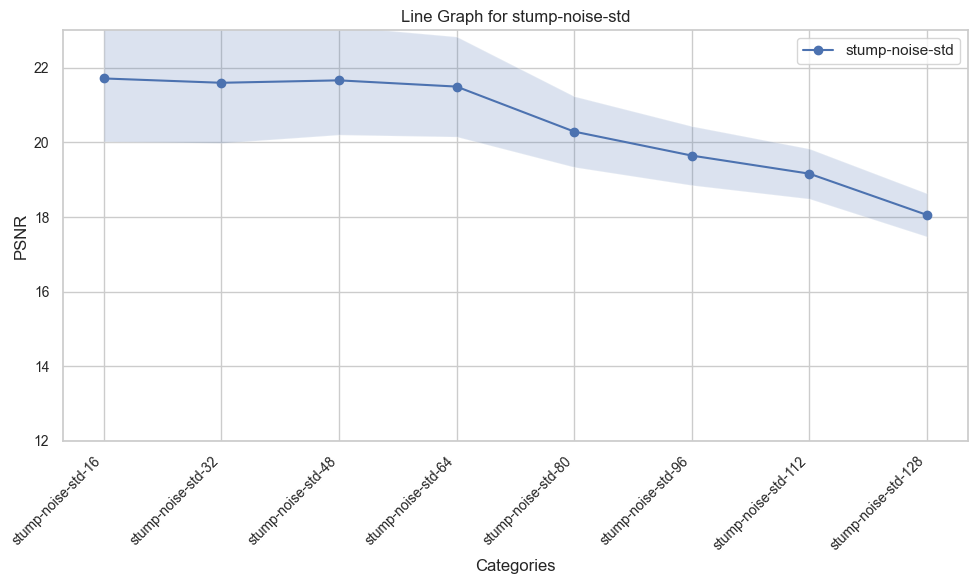

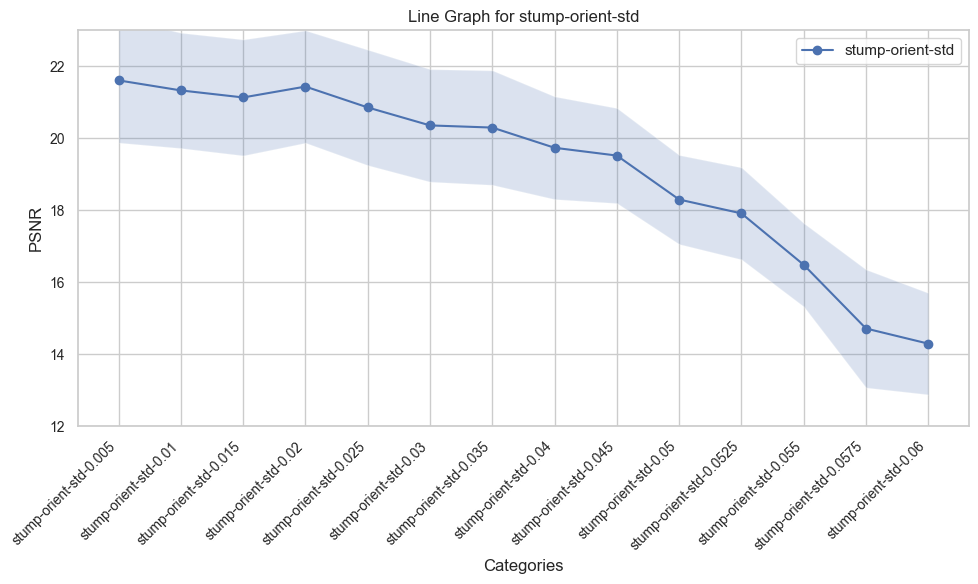

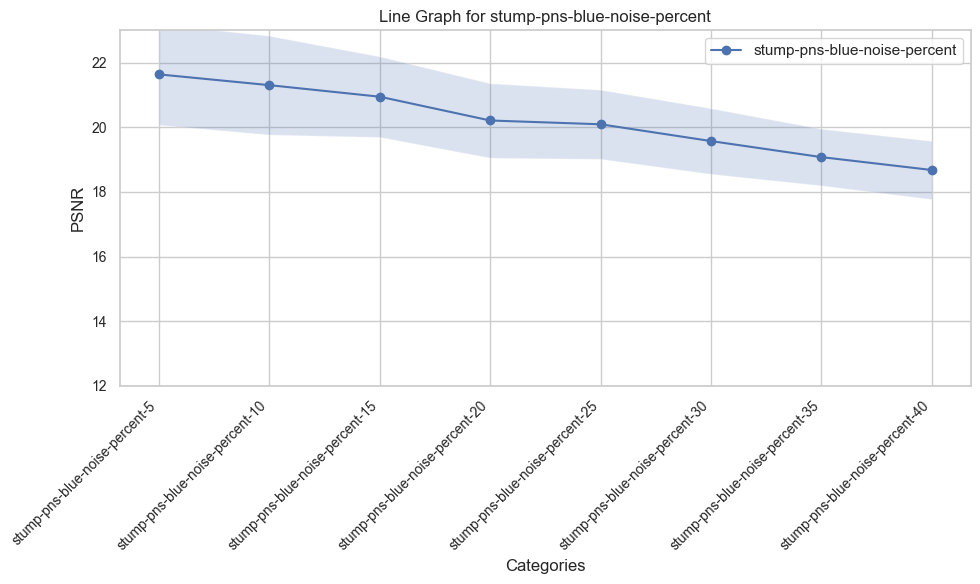

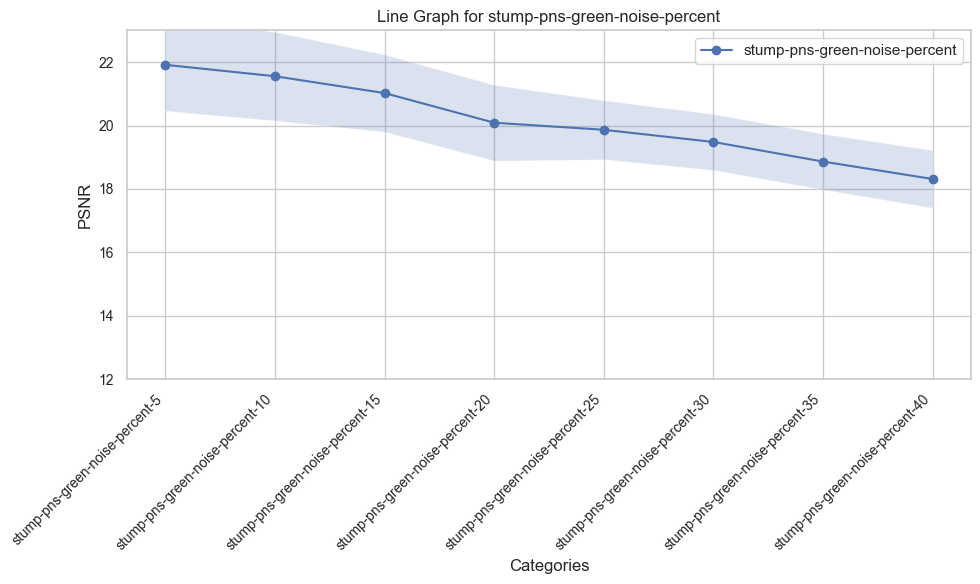

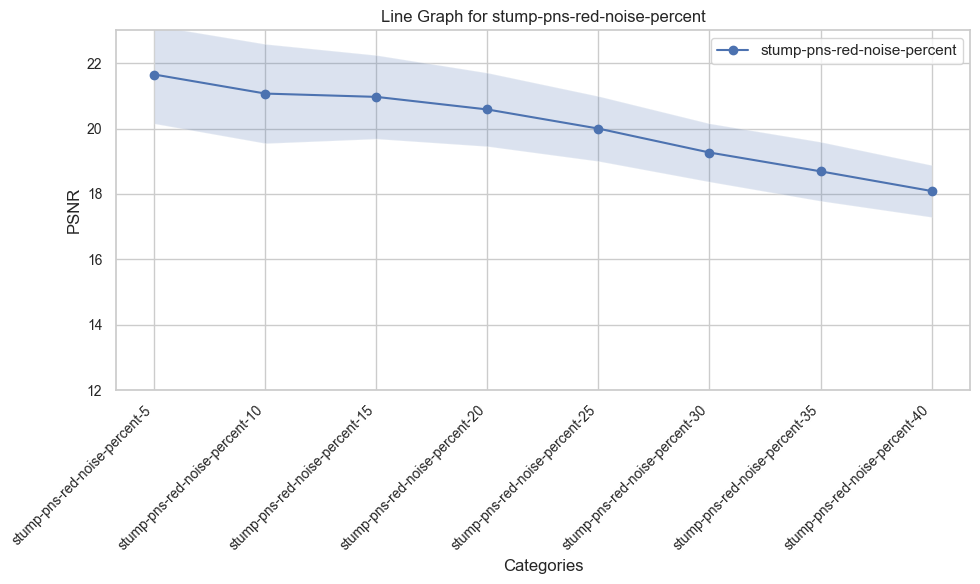

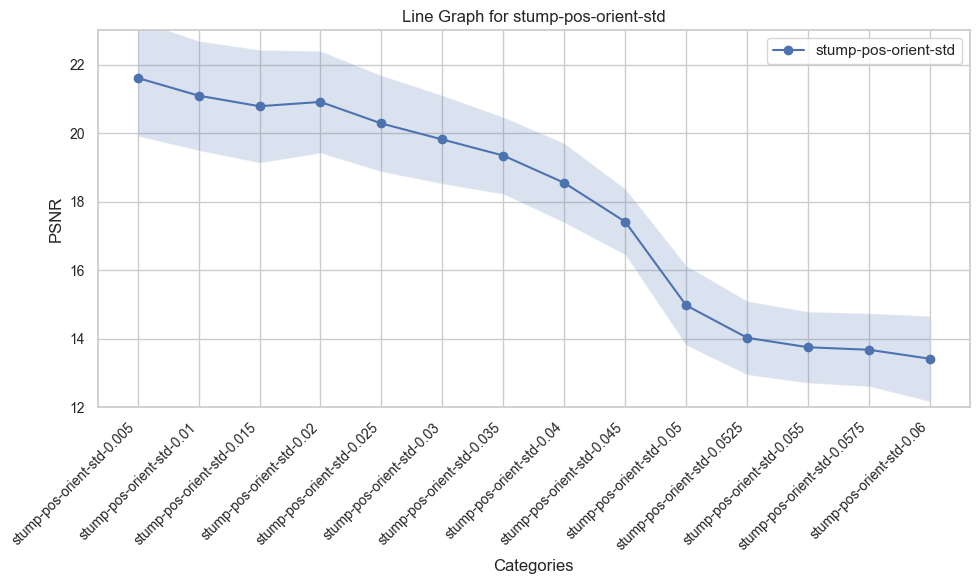

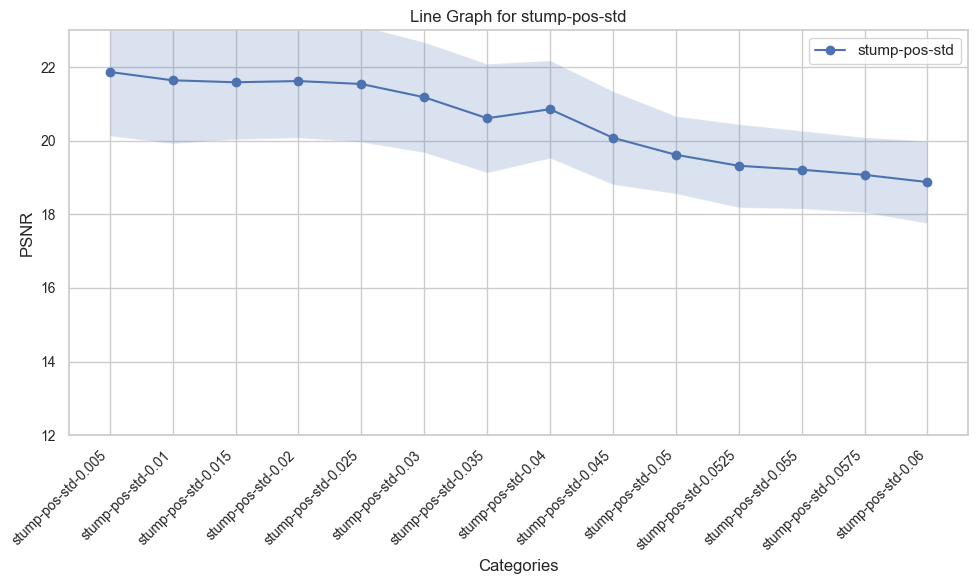

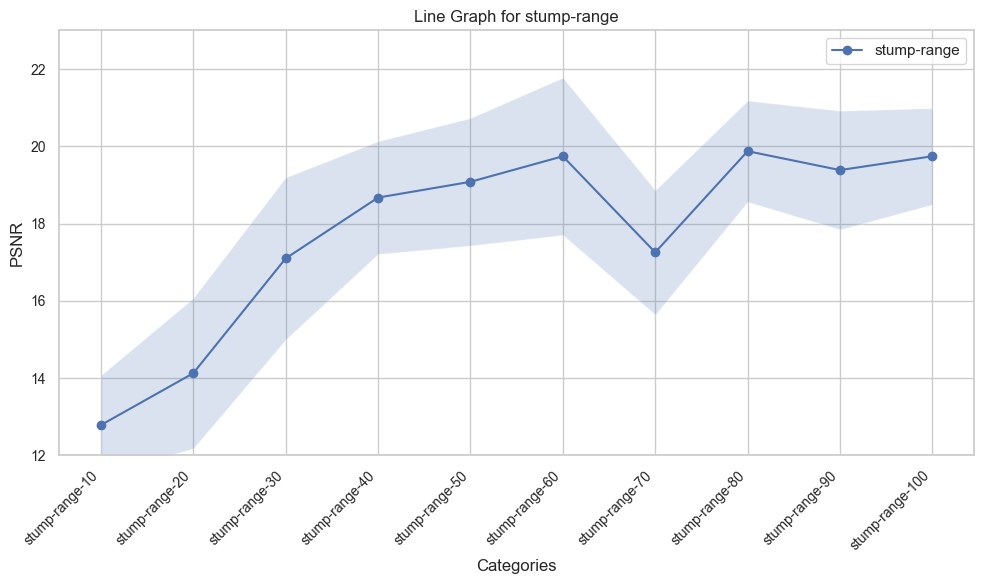

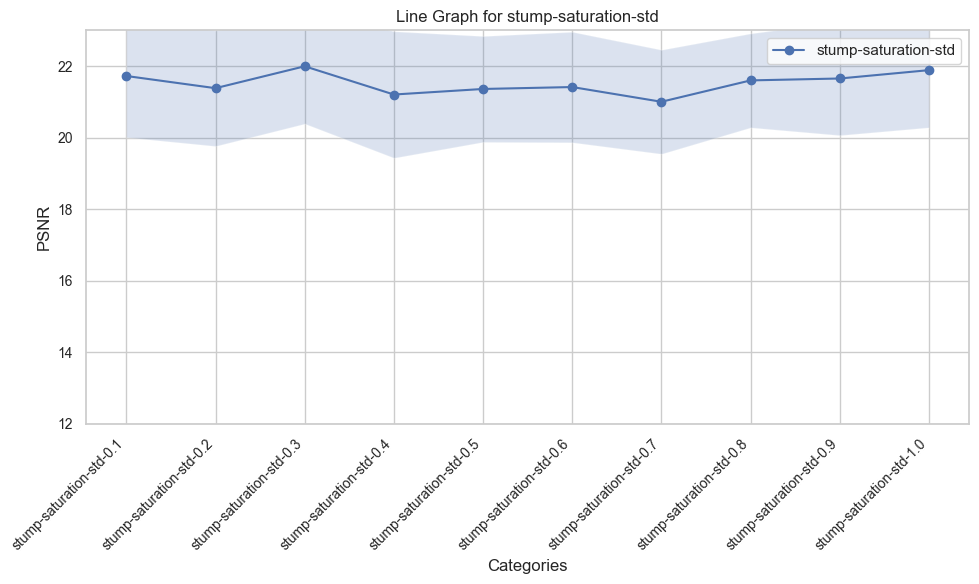

In [5]:
# Create separate subplots for each type
import matplotlib.pyplot as plt
import seaborn as sns

types = ['stump-noise-std', 'stump-orient-std', 'stump-pns-blue-noise-percent', 'stump-pns-green-noise-percent', 
         'stump-pns-red-noise-percent', 'stump-pos-orient-std', 'stump-pos-std', 'stump-range', 
         'stump-saturation-std']
sns.set(style="whitegrid", rc={"axes.labelsize": 12, "xtick.labelsize": 10, "ytick.labelsize": 10})

sorted_data = sorted(data, key=lambda x: (x[0].split('-')[1], float(x[0].split('-')[-1]), x[1]))
for type_name in types:
    type_data = [item for item in sorted_data if type_name in item[0]]
    # categories, values, _ = zip(*type_data)
    categories, values, stds = zip(*type_data)

    
    plt.figure(figsize=(10, 6))
    plt.plot(categories, values, marker='o', linestyle='-', label=type_name)
    plt.fill_between(categories, [value - std for value, std in zip(values, stds)], [value + std for value, std in zip(values, stds)], alpha=0.2)

    plt.ylim(12, 23)  # Set y-axis limits
    plt.xlabel('Categories')
    plt.ylabel('PSNR')
    plt.title(f'Line Graph for {type_name}')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
    plt.legend()
    plt.tight_layout()

    # output_file = os.path.join('C:\Stuff\Dataset-creation\plots', f'{type_name}_plot.png')
    # plt.savefig(output_file)
    plt.show()

In [6]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# types = ['stump-noise-std', 'stump-orient-std', 'stump-pns-blue-noise-percent', 'stump-pns-green-noise-percent',
#          'stump-pns-red-noise-percent', 'stump-pos-orient-std', 'stump-pos-std', 'stump-range',
#          'stump-saturation-std']

# # Set Seaborn style
# sns.set(style="whitegrid", rc={"axes.labelsize": 12, "xtick.labelsize": 10, "ytick.labelsize": 10})

# sorted_data = sorted(data, key=lambda x: (x[0].split('-')[1], float(x[0].split('-')[-1]), x[1]))

# for type_name in types:
#     type_data = [item for item in sorted_data if type_name in item[0]]
#     categories, values, stds = zip(*type_data)

#     # Add a red line with shaded standard deviation
#     single_value = benchmark_psnr  # Replace 0 with the index of the desired value
#     single_std = benchmark_psnr_std  # Replace 0 with the index of the desired standard deviation

#     plt.figure(figsize=(10, 6))
#     plt.plot(categories, values, marker='o', linestyle='-', label=type_name)
#     plt.fill_between(categories, [value - std for value, std in zip(values, stds)],
#                      [value + std for value, std in zip(values, stds)], alpha=0.2, label='St.D. of run')

#     # Add a red line with shaded standard deviation
#     plt.axhspan(single_value - single_std, single_value + single_std, facecolor='red', alpha=0.2, label='St.D. of benchmark run')
#     plt.axhline(y=single_value, color='red', linestyle='--', label='Benchmark run')

#     plt.ylim(12, 24)  # Set y-axis limits
#     plt.xlabel('Categories')
#     plt.ylabel('PSNR')
#     plt.title(f'Line Graph for {type_name}')
#     plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
#     plt.legend()
#     plt.tight_layout()

#     plt.show()


In [11]:
df

,category,value,std,type
0,stump-every-2,21.647285,1.542605,Unknown
1,stump-every-3,21.808588,1.470476,Unknown
2,stump-every-4,21.059649,1.144500,Unknown
3,stump-every-5,20.912481,1.279729,Unknown
4,stump-every-6,21.728569,1.460834,Unknown
...,...,...,...,...
104,stump-saturation-std-0.6,21.416605,1.545800,stump-saturation-std
105,stump-saturation-std-0.7,21.004843,1.454630,stump-saturation-std
106,stump-saturation-std-0.8,21.602377,1.314933,stump-saturation-std
107,stump-saturation-std-0.9,21.655798,1.585148,stump-saturation-std


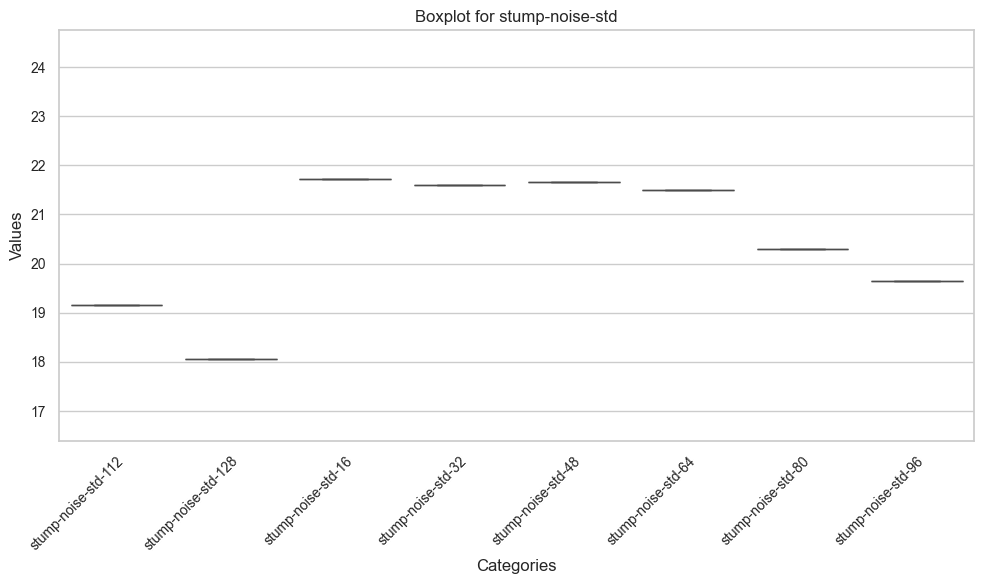

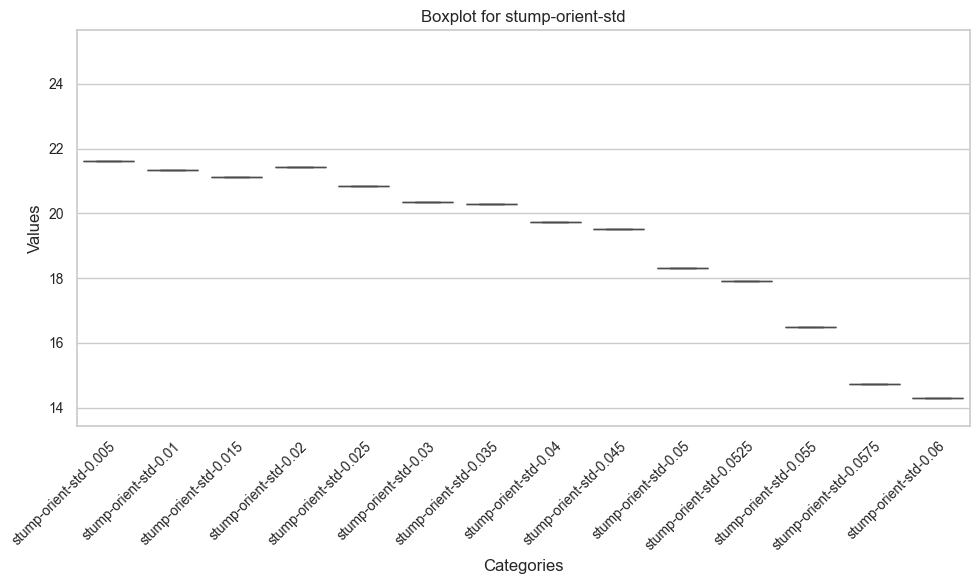

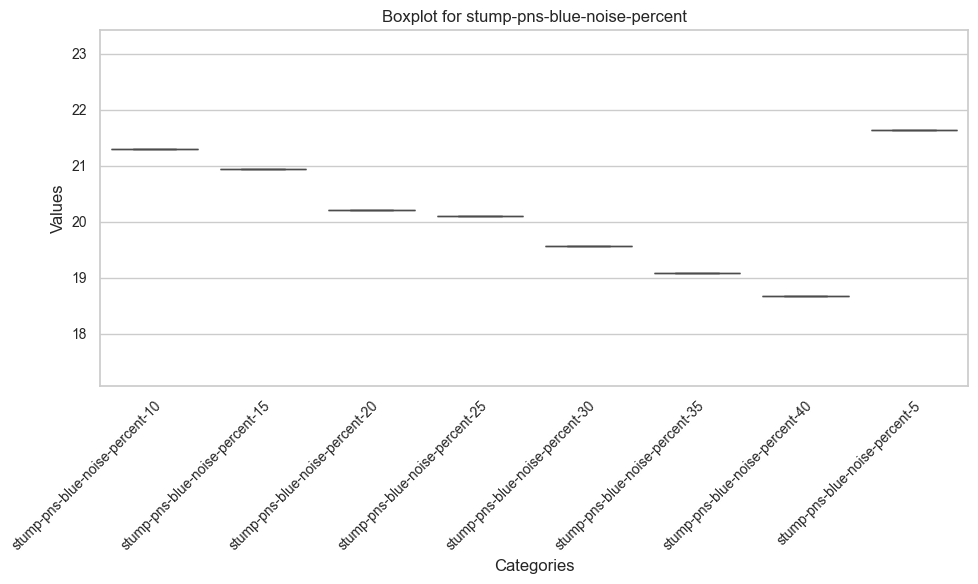

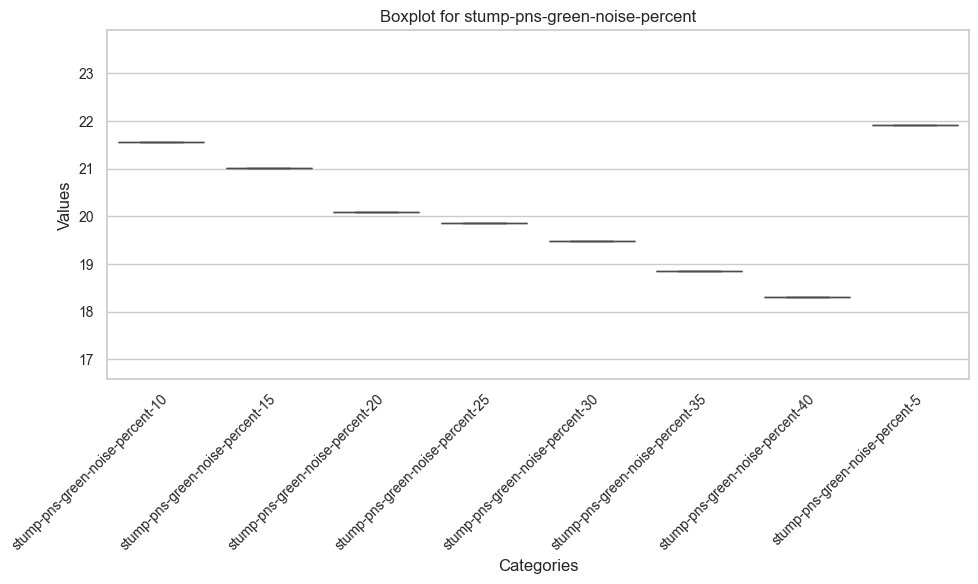

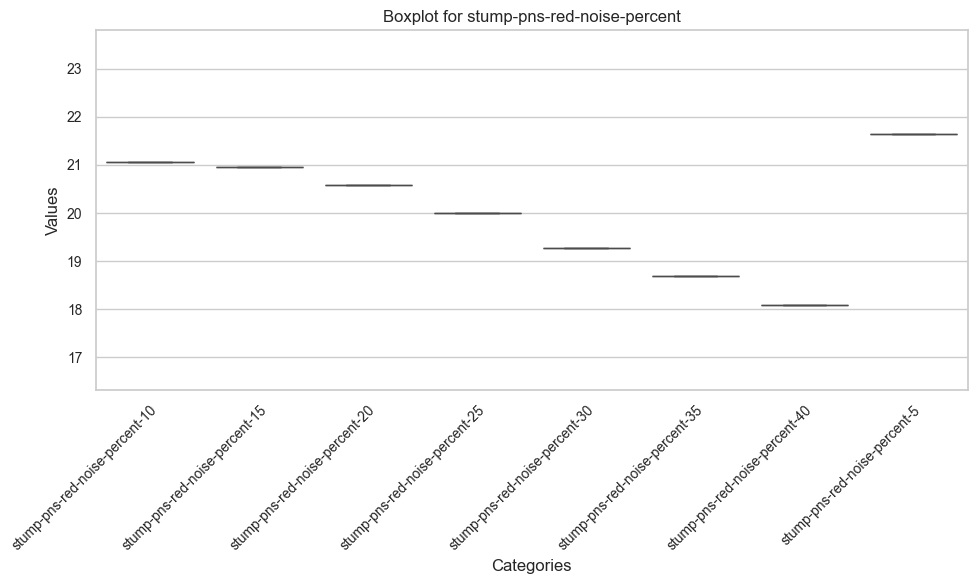

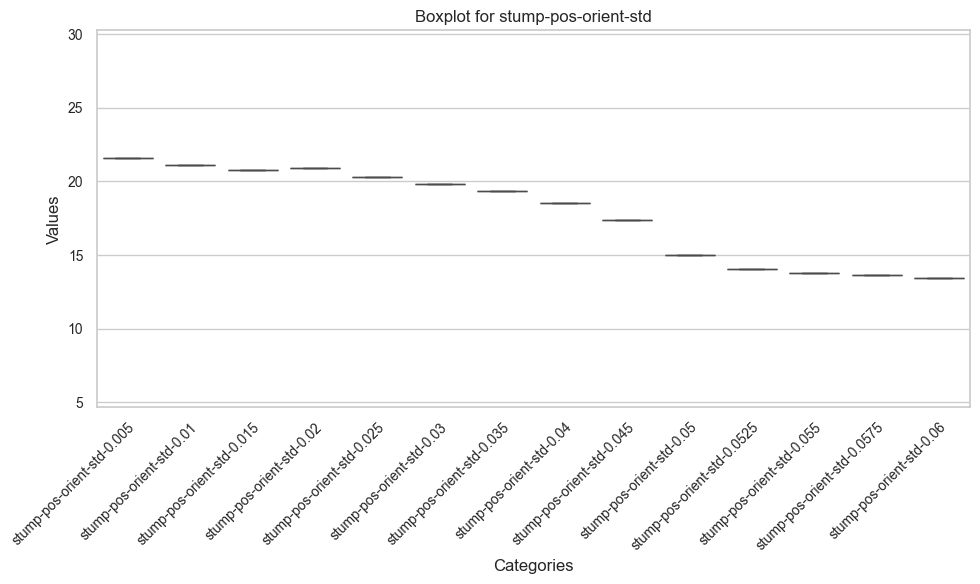

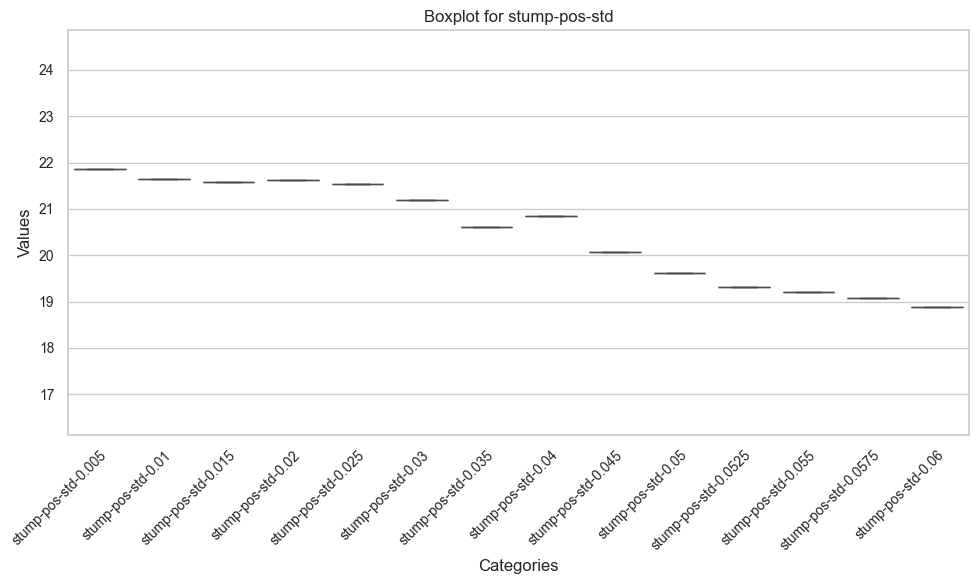

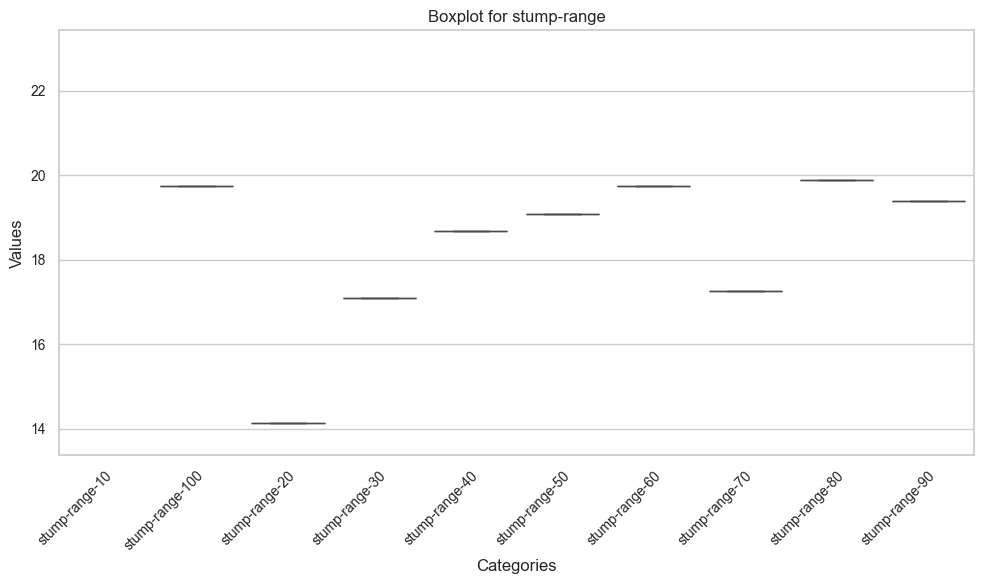

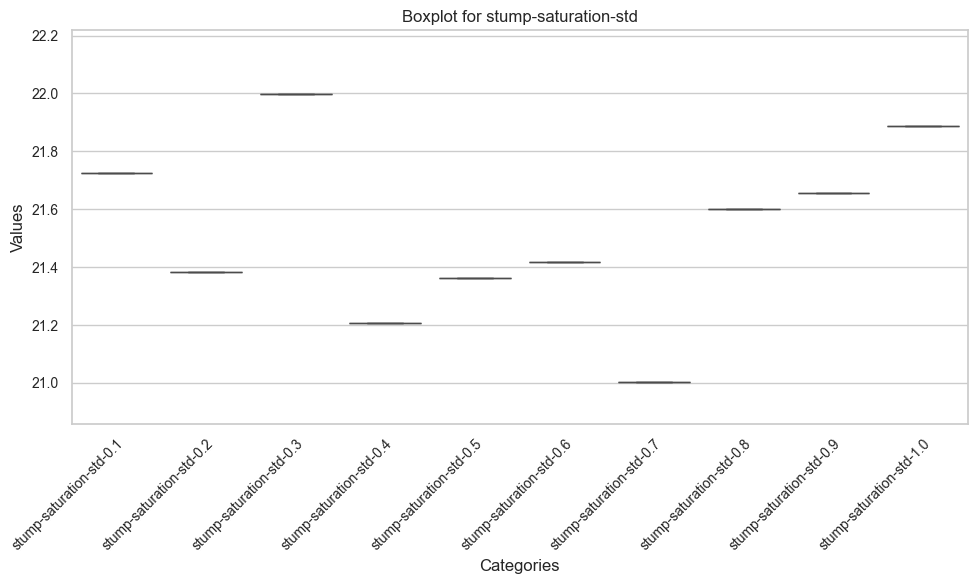

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'data' is a list of tuples with the format (category, value, std)
# and that you want to create boxplots for 'values' across different 'categories' for each 'type'

types = ['stump-noise-std', 'stump-orient-std', 'stump-pns-blue-noise-percent', 
         'stump-pns-green-noise-percent', 'stump-pns-red-noise-percent', 'stump-pos-orient-std', 
         'stump-pos-std', 'stump-range', 'stump-saturation-std']

# Convert your sorted data into a pandas DataFrame for easier manipulation with seaborn
df = pd.DataFrame(data, columns=['category', 'value', 'std'])
df['type'] = df['category'].apply(lambda x: next((t for t in types if t in x), 'Unknown'))

sns.set(style="whitegrid", rc={"axes.labelsize": 12, "xtick.labelsize": 10, "ytick.labelsize": 10})

for type_name in types:
    # Filter data for the current type
    type_df = df[df['type'] == type_name]
    
    plt.figure(figsize=(10, 6))
    ax = sns.boxplot(x='category', y='value', data=type_df)
    
    # Improve the visibility of the boxplot by setting appropriate y-limits
    # Calculate the interquartile range to focus the plot on the main data distribution
    q1 = type_df['value'].quantile(0.25)
    q3 = type_df['value'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    ax.set_ylim(lower_bound, upper_bound)
    
    plt.xlabel('Categories')
    plt.ylabel('Values')
    plt.title(f'Boxplot for {type_name}')
    
    # Rotate x-axis labels for better visibility
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    plt.tight_layout()
    
    # Uncomment the next line to save the figure
    # plt.savefig(f'{type_name}_boxplot.png')
    plt.show()


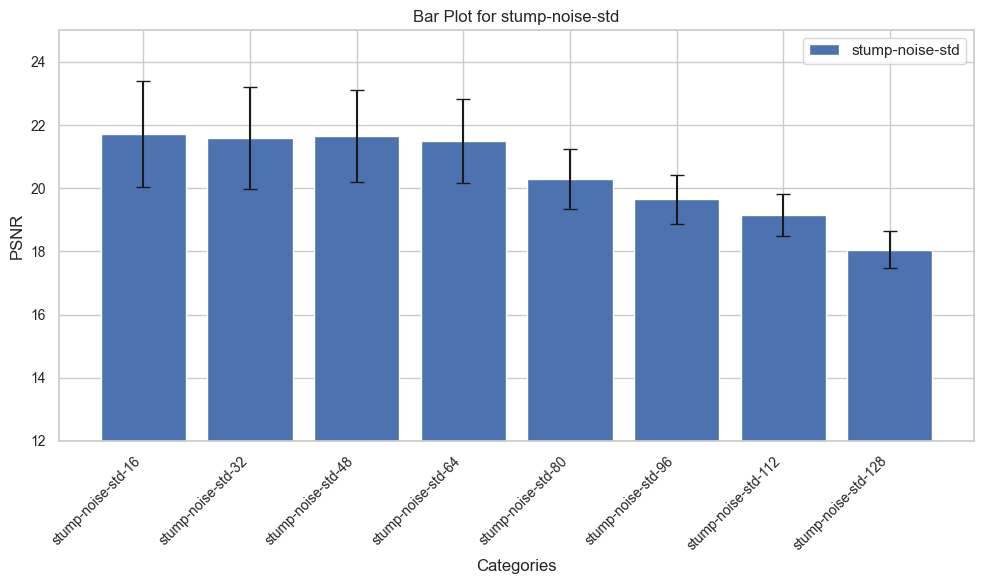

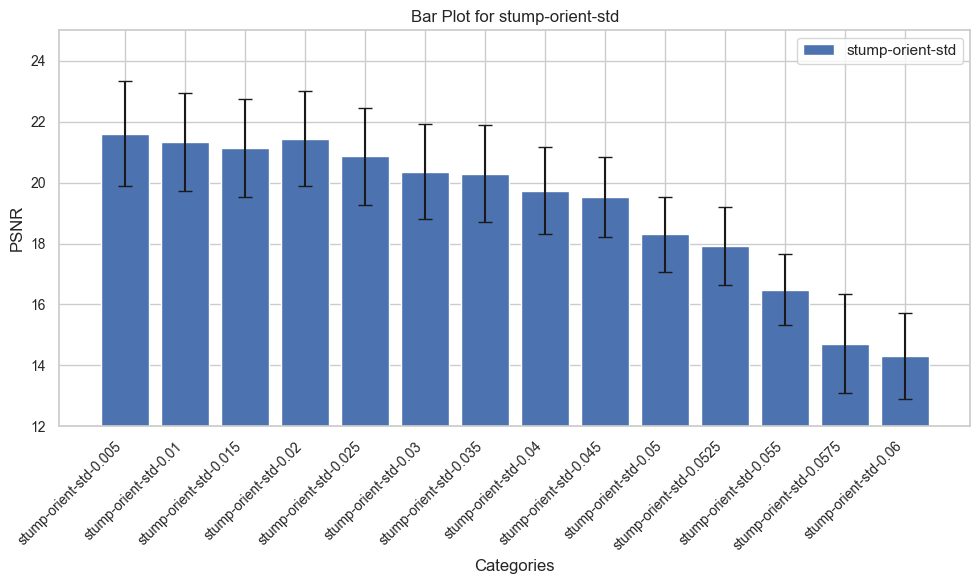

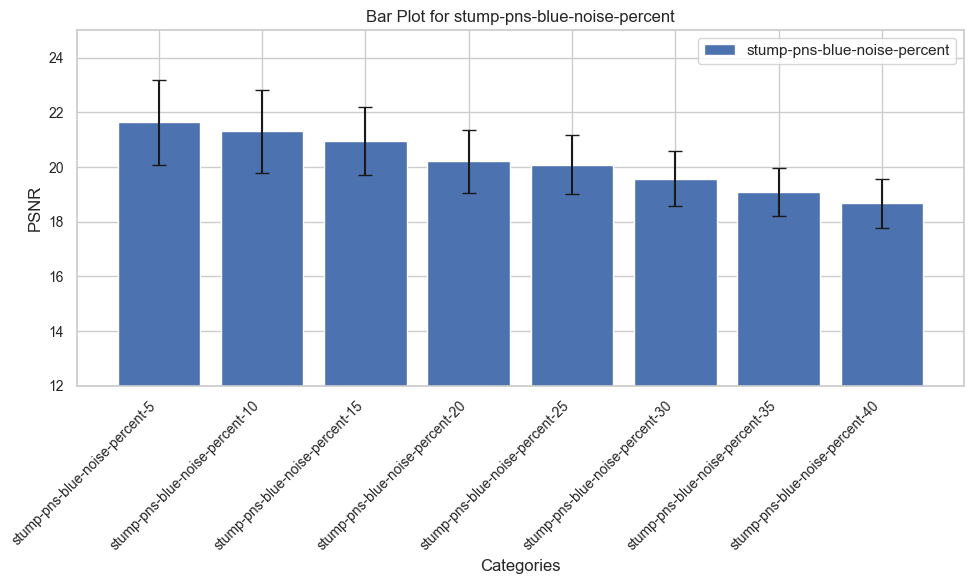

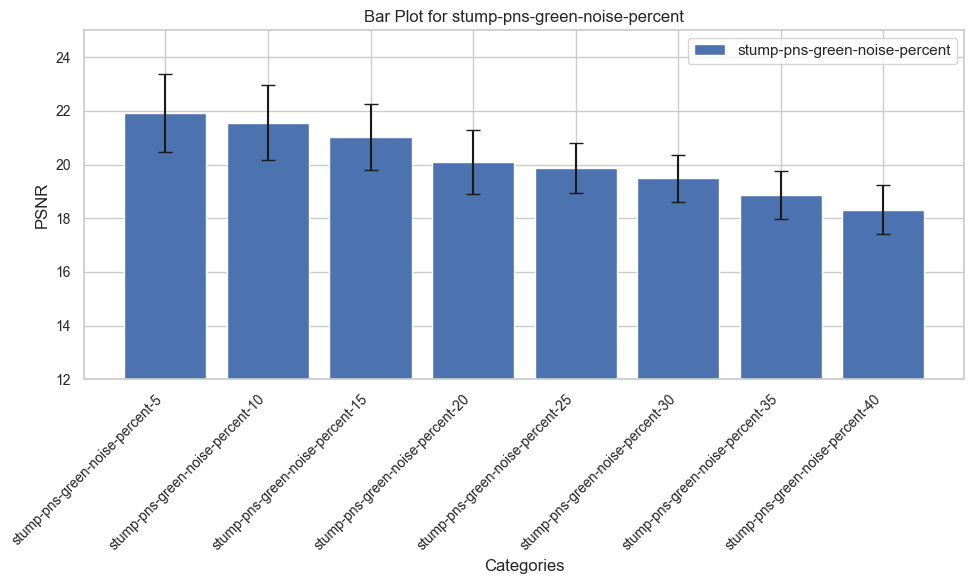

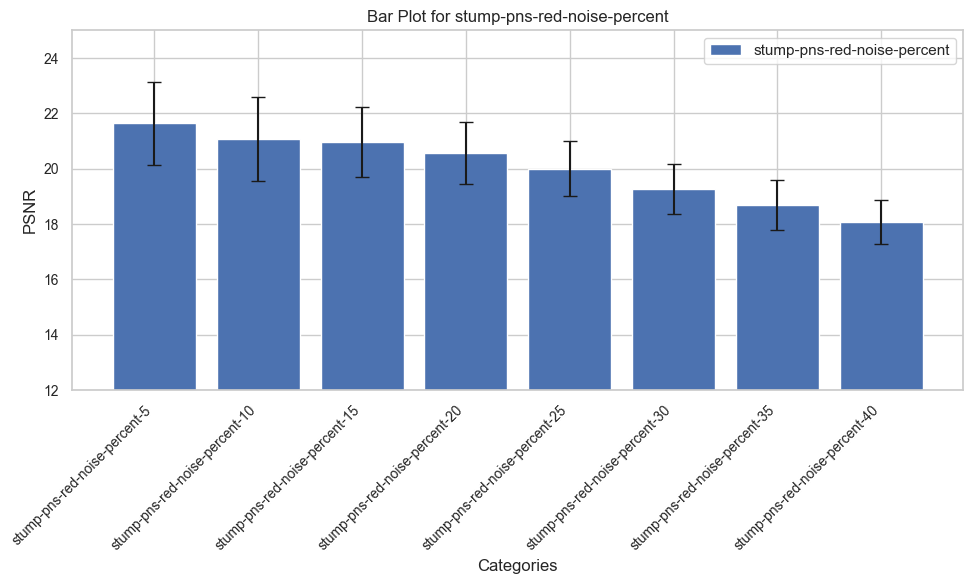

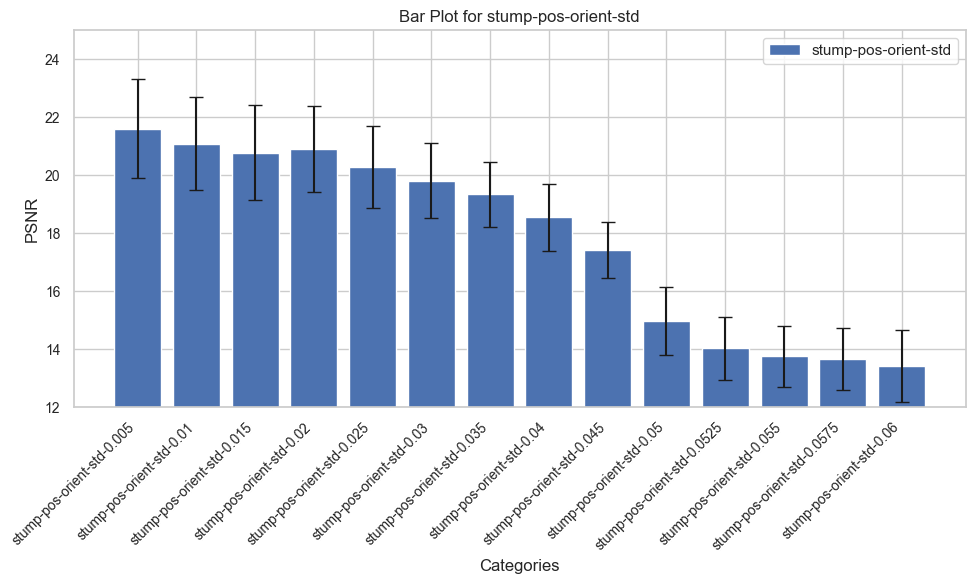

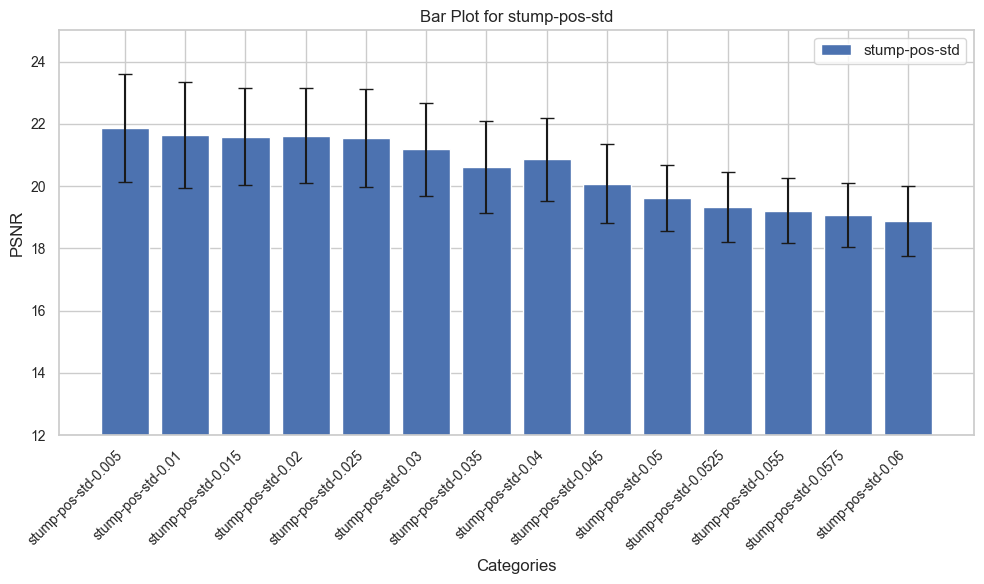

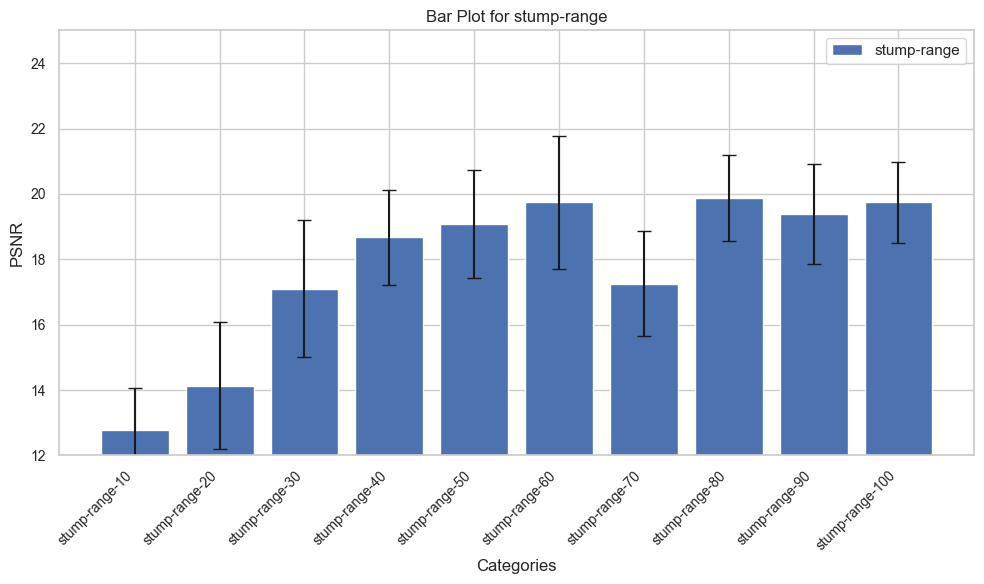

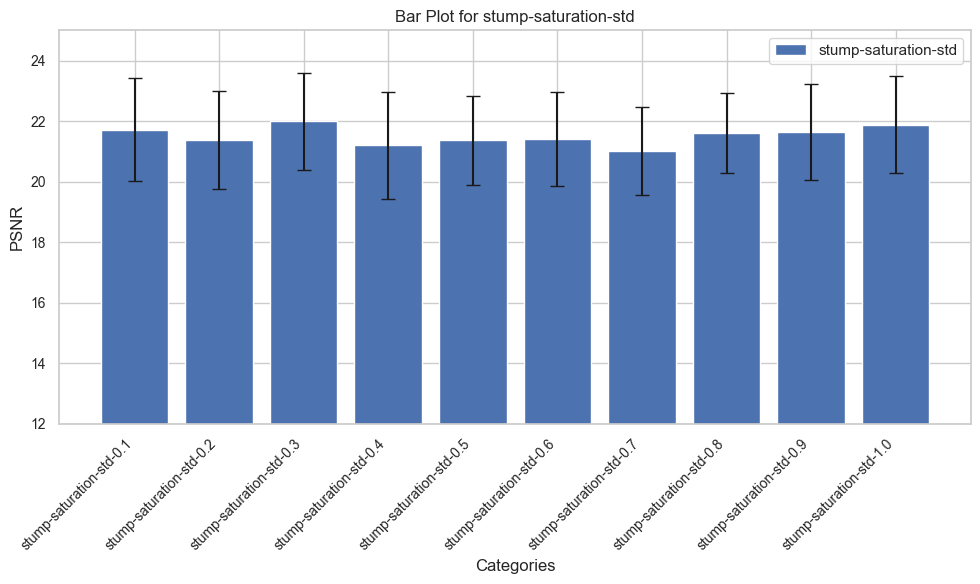

ValueError: not enough values to unpack (expected 3, got 0)

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'data' is a list of tuples with the format (category, value, std)
# We'll use this structure to create bar plots.

types = ['stump-noise-std', 'stump-orient-std', 'stump-pns-blue-noise-percent', 
         'stump-pns-green-noise-percent', 'stump-pns-red-noise-percent', 'stump-pos-orient-std', 
         'stump-pos-std', 'stump-range', 'stump-saturation-std', 'stump-sparce']

sns.set(style="whitegrid", rc={"axes.labelsize": 12, "xtick.labelsize": 10, "ytick.labelsize": 10})

sorted_data = sorted(data, key=lambda x: (x[0].split('-')[1], float(x[0].split('-')[-1]), x[1]))

for type_name in types:
    type_data = [item for item in sorted_data if type_name in item[0]]
    categories, values, stds = zip(*type_data)
    
    plt.figure(figsize=(10, 6))
    
    # Create a bar plot with error bars
    plt.bar(categories, values, yerr=stds, capsize=5, label=type_name)
    
    plt.ylim(12, 25)  # Set y-axis limits
    plt.xlabel('Categories')
    plt.ylabel('PSNR')
    plt.title(f'Bar Plot for {type_name}')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
    plt.legend()
    plt.tight_layout()
    
    # Uncomment the next line to save the figure to a file
    # output_file = os.path.join('C:/Stuff/Dataset-creation/plots', f'{type_name}_barplot.png')
    # plt.savefig(output_file)
    plt.show()
